# N-Gram Language Model

## Part 1: Given a sentence, calculate its probability

### N-gram
P(“its water is so transparent”) =  P(its) × P(water|its) ×  P(is|its water) ×  P(so|its water is) ×  P(transparent|its water is so)
### Bigram
P(“its water is so transparent”) =  P(its) × P(water|its) ×  P(is|water) ×  P(so|is) ×  P(transparent|so)
### Trigram
P(“its water is so transparent”) =  P(its) × P(water|its) ×  P(is|its water) ×  P(so|water is) ×  P(transparent|is so)

- First Make a basic lookup table and n-1 gram count for each word against its context window

In [35]:
# Muhammad Huzaifa
# Roll No: 03-3-1-034-2022

corpus = open('transcript.txt', 'r').read()
training_sentences = corpus.split('\n')

# Set n-gram limit
n = 3 # bigram

### Vocabulary and N-Gram Count Generation

This code processes training sentences to build a vocabulary set, a lookup table for words, and an n-gram count dictionary:

1. **Initialize Data Structures**:
    - `vocabulary`: Unique words.
    - `words_lookup`: Word counts given context.
    - `ngram_count`: Context (n-1 gram) counts.

2. **Process Sentences**:
    - Split sentences into tokens, remove the first token (timestamp).
    - Update `vocabulary` with tokens.
    - For each word, update `ngram_count` and `words_lookup` based on the context window.

3. **Calculate Vocabulary Size**:
    - Compute and print the size of `vocabulary`.
    - Print `words_lookup`.



In [ ]:
vocabulary = set()

words_lookup = {}
ngram_count = {}

for sentence in training_sentences:
    context_window = []
    training_tokens = sentence.split(' ')
    training_tokens.pop(0)         # Remove the timestamp token  
    vocabulary.update(training_tokens)

    for word in training_tokens:
        context_tuple = tuple(context_window)

        if (context_tuple not in ngram_count):
            ngram_count[context_tuple] = 0
        ngram_count[context_tuple] += 1
        if word not in words_lookup:
            words_lookup[word] = {}
        
        if context_tuple in words_lookup[word]:
            words_lookup[word][context_tuple] += 1
        else:
            words_lookup[word][context_tuple] = 1
        
        if len(context_window) == n - 1:
            context_window.pop(0)
        context_window.append(word)

vocabulary_size = len(vocabulary)

print(vocabulary_size)
print(words_lookup)

1994
{'okay': {(): 136, ('.', '.'): 1, ('dollars', '.'): 1, ('[mm]', '.'): 1, ('okay', '.'): 1, ('would', 'be'): 2, ('oh',): 2, ('berkeley', 'is'): 1, ('cost', 'is'): 3, ("it's",): 2, ('distance', "it's"): 1, ('food', 'is'): 4, ('anywhere', 'is'): 2, ('[lip_smack]',): 3, ("anything's",): 1, ('price', 'is'): 1, ('[um]', '[laughter]'): 1, ('[loud_breath]',): 2, ('it', 'again'): 1, ('', "it's"): 1, ('dinner', 'is'): 2, ('will', 'be'): 2, ('[um]',): 2}, "let's": {('okay',): 16, (): 213, ('range', '.'): 1, ('cambod-', '[um]'): 1, ('then', "<let's>"): 1, ('[loud_breath]', '[lip_smack]'): 1, ('to', 'spend'): 1, ('to', 'walk'): 1, ('has', '[uh]'): 1, ('okay', '.'): 2, ('[uh]',): 3, ('food', '.'): 1, ('[laughter]',): 2, ('.', '[uh]'): 1, ('[lip_smack]',): 3, ('oh', '[um]'): 1, ('i', 'said'): 1, ('[tap]',): 1, ('[noise]', '[unintelligible]'): 1, ('well',): 1, ('m-(uch)>', '[uh]'): 1, ('here', '.'): 1, ('[uh]', 'th-'): 1, ('so',): 3, ('.', '[laughter]'): 1, ('of', ''): 1, ('all', 'right'): 1, ('n

### Predicting Next Tokens

This code defines two functions: `get_probability` and `predict_next_tokens`.

- **`get_probability(word, context)`**: Calculates the probability of a word given its context using add-one smoothing.
- **`predict_next_tokens(sentence, num_tokens)`**: Predicts the next `num_tokens` tokens for a given input sentence based on the n-gram model.

- For zero count words add smoothening (for now, we're using add 1 smoothing but Kneser-Ney Smoothing would be better choice if implemented)

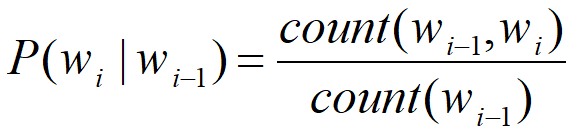

In [41]:
def get_probability(word: str, context: tuple):
    if word in words_lookup and context in words_lookup[word]:
        numerator = words_lookup[word].get(context, 0) + 1
    else:
        numerator = 1
    denominator = ngram_count.get(context, 0) + vocabulary_size
    return numerator / denominator

def predict_next_tokens(sentence, num_tokens=1):

    tokens = [token for token in sentence.split(' ') if token]
    context_window = tokens[-min(len(tokens), n-1):]
    
    predicted_tokens = []
    
    for _ in range(num_tokens):
        context_tuple = tuple(context_window)
        
        best_word = None
        best_prob = -1
        
        for word in vocabulary:
            prob = get_probability(word, context_tuple)
            if prob > best_prob:
                best_prob = prob
                best_word = word
        
        if best_word is None:
            break
            
        predicted_tokens.append(best_word)
        
        if len(context_window) == n - 1:
            context_window.pop(0)
        context_window.append(best_word)
    
    return predicted_tokens

input_sentence = "i will have to"
predictions = predict_next_tokens(input_sentence, 4)
print(f"Input: {input_sentence}")
print(f"Predicted next tokens: {' '.join(predictions)}")

Input: i will have to
Predicted next tokens: be within ten minutes


- Now that we have our probability tables, we can now predict the probability of a given sentence

In [42]:
sentence = "okay we will have a dinner"

tokens = [token for token in sentence.split(' ') if token]

probability = 1.0
context_window = []

for word in tokens:
    context_tuple = tuple(context_window)
    
    probability *= get_probability(word, context_tuple)

    # slide context_window
    if len(context_window) == n - 1:
        context_window.pop(0)
    context_window.append(word)

print("The probability of given sentence is: " + str(probability))

The probability of given sentence is: 1.1016186234978056e-18
